In [1]:
import os
os.chdir('../')

In [2]:
import normet.intervention as interv

In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_excel(r'./normet/datasets/Intervention/ChinaAQ_Weekly.xlsx',parse_dates=['date'])

In [5]:
df=df.query(f"date>='2015-05-01'").query(f"date<'2016-04-30'")

In [6]:
control_pool=["Dongguan", "Zhongshan" , "Foshan", "Beihai"
               , "Nanning","Nanchang" , "Xiamen", "Taizhou" 
               , "Ningbo","Guangzhou" , "Huizhou", "Hangzhou" 
               , "Liuzhou", "Shantou", "Jiangmen", "Heyuan", "Quanzhou","Haikou" , "Shenzhen", "Wenzhou", "Huzhou"
               , "Zhuhai", "Fuzhou", "Shaoxing", "Zhaoqing","Zhoushan"  
               , "Quzhou", "Jinhua", "Shaoguan" , "Sanya"
               , "Jieyang" , "Meizhou", "Shanwei" 
               , "Zhanjiang" , "Chaozhou", "Maoming" , "Yangjiang"]

In [7]:
df=df[df['ID'].isin(control_pool+["2+26 cities"])]

In [8]:
df.head()

,date,ID,CO,COwn,NO2,NO2wn,O3,O3_8h,O3_8hwn,O3wn,Ox,Oxwn,PM10,PM10wn,PM2.5,PM2.5wn,SO2,SO2wn
552,2015-05-03,2+26 cities,1.277812,1.328918,38.484623,45.068304,83.690318,133.060175,90.980089,65.825884,60.984249,54.415501,134.523758,139.447383,82.221006,73.876656,32.971551,36.822724
560,2015-05-10,2+26 cities,1.113243,1.298979,35.289414,44.352582,70.075957,103.363985,90.875789,66.100641,52.659234,54.337364,111.771975,134.412595,58.313419,69.386309,27.898696,35.284317
568,2015-05-17,2+26 cities,0.996762,1.274902,35.810778,43.981644,83.598553,125.082867,91.245896,66.418891,59.588514,54.389203,117.075504,129.474025,52.802738,67.146002,29.642007,34.742172
576,2015-05-24,2+26 cities,1.031094,1.267058,39.838150,43.398110,96.838000,149.709652,92.792728,66.695864,68.180477,54.529002,117.650986,121.537391,61.278043,65.876502,34.972942,34.482513
584,2015-05-31,2+26 cities,1.297053,1.285556,37.988483,43.548340,109.770206,165.029315,92.427553,66.419975,73.600167,54.475052,143.115653,126.681810,88.963408,67.239277,33.903061,34.490734


In [9]:
df['after_treatment']=df['date']>'2015-10-23'

In [10]:
xx=interv.scm(df,'SO2wn','date','ID',"2+26 cities",control_pool,'after_treatment')

In [11]:
xy=interv.scm_parallel(df,'SO2wn','date','ID',control_pool,'after_treatment')

<Axes: xlabel='date'>

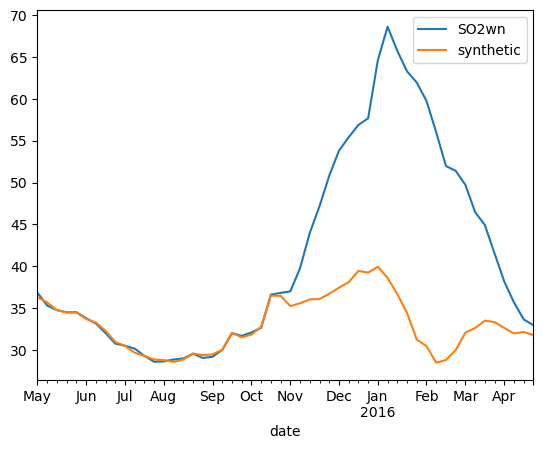

In [12]:
xx[['SO2wn','synthetic']].plot()

In [13]:
xz=interv.sdid_effects(df,'SO2wn','date','ID','2+26 cities',control_pool,'after_treatment')

In [14]:
xm=interv.sdid_parallel(df,'SO2wn','date','ID',control_pool,'after_treatment')

In [15]:
import matplotlib.pyplot as plt

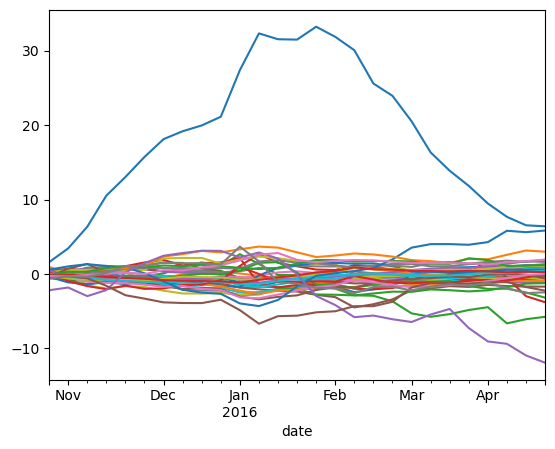

In [16]:
fig,ax=plt.subplots()
for i,city in enumerate(list(xm['ID'].unique())):
    xm[xm['ID']==city]['effects'].plot(ax=ax)

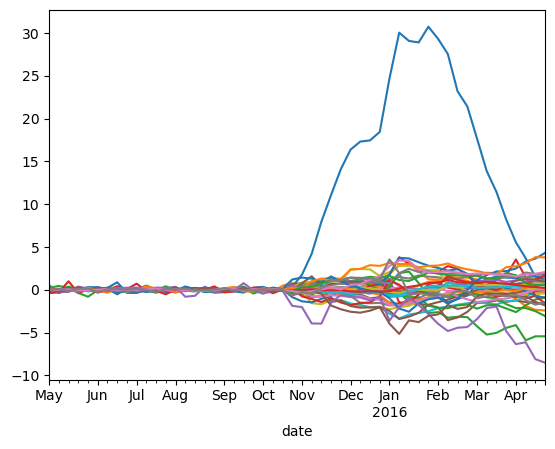

In [17]:
fig,ax=plt.subplots()
for i,city in enumerate(list(xy['ID'].unique())):
    xy[xy['ID']==city]['effects'].plot(ax=ax)